In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [31]:
from nltk import pos_tag

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, accuracy_score

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [8]:
from nltk.corpus import stopwords

In [10]:
import psycopg2

In [9]:
load_dotenv()

True

In [13]:
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [14]:
DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

In [15]:
engine = create_engine(DATABASE_URL)

In [17]:
train_df = pd.read_sql("SELECT * FROM train_data", engine)

In [18]:
train_df.head()

,id,subject,body,text,category,category_id
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1
1,spam_1629,Your Amazon was used on new device,Your $5000 refund is processed. Claim: bit.ly/...,Your Amazon was used on new device Your $5000 ...,spam,3
2,spam_322,Re: Your Google inquiry,"Hi, following up about your Google application...","Re: Your Google inquiry Hi, following up about...",spam,3
3,social_media_80,Digital Ritual Experience Creation,Cross-cultural ceremony design. Join: virtualr...,Digital Ritual Experience Creation Cross-cultu...,social_media,2
4,forum_1351,"Your post was moved to ""Programming Help""","Trending: ""cooking"" (258 comments). View: supp...","Your post was moved to ""Programming Help"" Tren...",forum,0


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10780 entries, 0 to 10779
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           10780 non-null  object
 1   subject      10780 non-null  object
 2   body         10780 non-null  object
 3   text         10780 non-null  object
 4   category     10780 non-null  object
 5   category_id  10780 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 505.4+ KB


In [18]:
train_df.shape

(10780, 6)

In [19]:
train_df['category'].value_counts()

category
forum           1800
verify_code     1800
promotions      1796
social_media    1796
spam            1794
updates         1794
Name: count, dtype: int64

In [26]:
def clean_texts(col): 
    col = col.lower() 
    col = re.sub(r"\d+", " num ", col)  
    col = re.sub(r"[^\w\s!?]", "", col)  
    col = " ".join([word for word in col.split() if word not in stopwords.words('english')])  
    return col

In [43]:
def add_features(df):
    punctuations = ["!", "?", "...", "$", "%", "#", "*"]
    
    for col in ['subject', 'body', 'text']:
        # Character length
        df[f'{col}_char_len'] = df[col].apply(len)
        
        # Word length
        df[f'{col}_word_len'] = df[col].apply(lambda x: len(x.split()))
        
        # Sentence length
        df[f'{col}_sent_len'] = df[col].apply(lambda x: len(sent_tokenize(x)))
        
        # Avg word length
        df[f'{col}_avg_word_len'] = df[col].apply(
            lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0
        )
        
        # Punctuation counts
        for p in punctuations:
            safe_p = re.escape(p)  # escape $, *, ...
            df[f"{col}_{p}_count"] = df[col].str.count(safe_p)
        
        # Uppercase ratio
        df[f'{col}_upper_ratio'] = df[col].apply(
            lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
        )
        
        # Digit count
        df[f'{col}_digit_count'] = df[col].apply(lambda x: sum(c.isdigit() for c in x))
    
    return df

In [24]:
train_df['combined_text'] = train_df['subject']+ " " +train_df['body']+ " " +train_df['text'] 

In [25]:
train_df['combined_text'][2]

'Re: Your Google inquiry Hi, following up about your Google application. Rates dropped to 0.9%! Apply now: phishing-site.com. STOP to opt out. Re: Your Google inquiry Hi, following up about your Google application. Rates dropped to 0.9%! Apply now: phishing-site.com. STOP to opt out.'

In [27]:
train_df['combined_text'] = train_df['combined_text'].astype(str).apply(clean_texts)

In [28]:
train_df['combined_text'][2]

'google inquiry hi following google application rates dropped num num ! apply phishingsitecom stop opt google inquiry hi following google application rates dropped num num ! apply phishingsitecom stop opt'

In [25]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [26]:
X_tfidf = tfidf.fit_transform(train_df['combined_text'])

In [27]:
X_tfidf

<10780x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 265475 stored elements in Compressed Sparse Row format>

In [45]:
train_df = add_features(train_df)

In [46]:
train_df.head()

,id,subject,body,text,category,category_id,combined_text,subject_char_len,subject_word_len,subject_sent_len,...,text_avg_word_len,text_!_count,text_?_count,text_..._count,text_$_count,text_%_count,text_#_count,text_*_count,text_upper_ratio,text_digit_count
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1,anniversary special buy one get one free loyal...,41,7,1,...,5.650000,0,0,0,2,0,0,0,0.090909,10
1,spam_1629,Your Amazon was used on new device,Your $5000 refund is processed. Claim: bit.ly/...,Your Amazon was used on new device Your $5000 ...,spam,3,amazon used new device num refund processed cl...,34,7,1,...,5.882353,0,0,0,1,0,0,0,0.043103,6
2,spam_322,Re: Your Google inquiry,"Hi, following up about your Google application...","Re: Your Google inquiry Hi, following up about...",spam,3,google inquiry hi following google application...,23,4,1,...,5.454545,1,0,0,0,1,0,0,0.078014,2
3,social_media_80,Digital Ritual Experience Creation,Cross-cultural ceremony design. Join: virtualr...,Digital Ritual Experience Creation Cross-cultu...,social_media,2,digital ritual experience creation crosscultur...,34,4,1,...,10.000000,0,0,0,0,0,0,0,0.058333,0
4,forum_1351,"Your post was moved to ""Programming Help""","Trending: ""cooking"" (258 comments). View: supp...","Your post was moved to ""Programming Help"" Tren...",forum,0,post moved programming help trending cooking n...,41,7,1,...,7.384615,0,0,0,0,0,0,0,0.046296,6


In [49]:
from scipy.sparse import hstack

In [54]:
engineered_features =  train_df.loc[:, "subject_char_len":]

In [55]:
engineered_features.head()

,subject_char_len,subject_word_len,subject_sent_len,subject_avg_word_len,subject_!_count,subject_?_count,subject_..._count,subject_$_count,subject_%_count,subject_#_count,...,text_avg_word_len,text_!_count,text_?_count,text_..._count,text_$_count,text_%_count,text_#_count,text_*_count,text_upper_ratio,text_digit_count
0,41,7,1,5.00,0,0,0,0,0,0,...,5.650000,0,0,0,2,0,0,0,0.090909,10
1,34,7,1,4.00,0,0,0,0,0,0,...,5.882353,0,0,0,1,0,0,0,0.043103,6
2,23,4,1,5.00,0,0,0,0,0,0,...,5.454545,1,0,0,0,1,0,0,0.078014,2
3,34,4,1,7.75,0,0,0,0,0,0,...,10.000000,0,0,0,0,0,0,0,0.058333,0
4,41,7,1,5.00,0,0,0,0,0,0,...,7.384615,0,0,0,0,0,0,0,0.046296,6


In [56]:
X_input = hstack([X_tfidf,engineered_features.values])

In [59]:
X_input

<10780x5039 sparse matrix of type '<class 'numpy.float64'>'
	with 462869 stored elements in COOrdinate format>

In [64]:
print(X_input.toarray())   

[[ 0.          0.          0.         ...  0.          0.09090909
  10.        ]
 [ 0.          0.          0.         ...  0.          0.04310345
   6.        ]
 [ 0.          0.          0.         ...  0.          0.07801418
   2.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.04511278
   2.        ]
 [ 0.19177226  0.19232423  0.         ...  0.          0.09722222
  18.        ]
 [ 0.          0.          0.         ...  0.          0.03418803
   5.        ]]


In [65]:
X_input.shape

(10780, 5039)

In [20]:
y = train_df['category_id']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_input,y, test_size=0.2, random_state=101)

In [63]:
def run_logistic_regression(X_train, X_test, y_train, y_test, feature_names=None):
    clf = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')  
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔹 Accuracy: {acc:.4f}\n")

    # Classification Report
    print("🔹 Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

    # Feature Importance
    if feature_names is not None:
        print("\n🔹 Top Features per Class:\n")
        for i, class_label in enumerate(clf.classes_):
            coef = clf.coef_[i]
            top_pos_idx = coef.argsort()[-10:][::-1]
            top_neg_idx = coef.argsort()[:10]

            print(f"\nClass: {class_label}")
            print("  Top Positive Features:")
            for idx in top_pos_idx:
                print(f"    {feature_names[idx]}: {coef[idx]:.4f}")

            print("  Top Negative Features:")
            for idx in top_neg_idx:
                print(f"    {feature_names[idx]}: {coef[idx]:.4f}")

    return clf


In [78]:
tfidf_features = tfidf.get_feature_names_out()

In [81]:
tfidf_features[:20]

array(['aa', 'aa num', 'ab', 'ab num', 'abc', 'abc airlines', 'accept',
       'acceptreject', 'acceptreject platformcomrequests',
       'acceptreject socialcomfriendspending', 'access',
       'access clearance', 'access code', 'access fall', 'access holiday',
       'access new', 'access num', 'access number', 'access summer',
       'accessibility'], dtype=object)

In [83]:
engineered_features_cols = ['subject_char_len', 'subject_word_len', 'subject_sent_len',
       'subject_avg_word_len', 'subject_!_count', 'subject_?_count',
       'subject_..._count', 'subject_$_count', 'subject_%_count',
       'subject_#_count', 'subject_*_count', 'subject_upper_ratio',
       'subject_digit_count', 'body_char_len', 'body_word_len',
       'body_sent_len', 'body_avg_word_len', 'body_!_count', 'body_?_count',
       'body_..._count', 'body_$_count', 'body_%_count', 'body_#_count',
       'body_*_count', 'body_upper_ratio', 'body_digit_count', 'text_char_len',
       'text_word_len', 'text_sent_len', 'text_avg_word_len', 'text_!_count',
       'text_?_count', 'text_..._count', 'text_$_count', 'text_%_count',
       'text_#_count', 'text_*_count', 'text_upper_ratio', 'text_digit_count']

In [84]:
all_feature_names = np.concatenate([tfidf_features, engineered_features_cols])

D:\BA-specialization\Anaconda_Setup\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\BA-specialization\Anaconda_Setup\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔹 Accuracy: 0.9429

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       367
           1       0.99      0.95      0.97       352
           2       0.93      0.93      0.93       349
           3       0.94      0.95      0.94       358
           4       0.92      0.91      0.91       345
           5       0.99      0.98      0.99       385

    accuracy                           0.94      2156
   macro avg       0.94      0.94      0.94      2156
weighted avg       0.94      0.94      0.94      2156



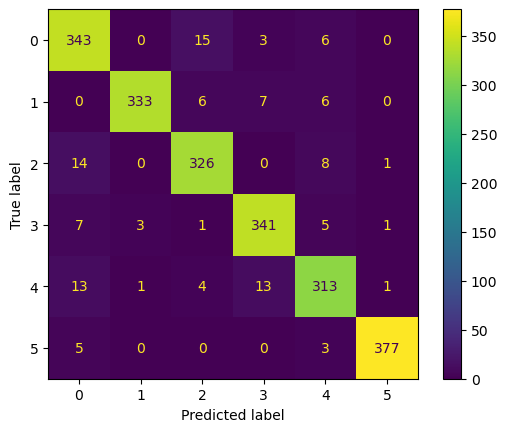


🔹 Top Features per Class:


Class: 0
  Top Positive Features:
    text_sent_len: 1.1517
    thread: 1.0050
    wikisitepage num: 0.8593
    wikisitepage: 0.8593
    forumcomthread num: 0.8451
    forumcomthread: 0.8451
    supportsiteticket num: 0.7688
    supportsiteticket: 0.7688
    forum: 0.7477
    discussion: 0.7150
  Top Negative Features:
    body_!_count: -1.9450
    body_$_count: -1.5438
    text_$_count: -1.4849
    text_!_count: -1.3315
    text_avg_word_len: -0.5968
    text_?_count: -0.5146
    body_?_count: -0.5146
    num num: -0.4861
    text_%_count: -0.4841
    subject_#_count: -0.4717

Class: 1
  Top Positive Features:
    text_%_count: 2.3520
    text_$_count: 2.2319
    body_%_count: 1.6337
    subject_$_count: 1.3678
    examplecom num: 1.0435
    examplecom: 1.0435
    shop: 1.0157
    shop examplecom: 0.8940
    body_$_count: 0.8640
    free: 0.7740
  Top Negative Features:
    body_sent_len: -0.7327
    text_#_count: -0.7308
    body_#_count: -0.4780
    text

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [86]:
run_logistic_regression(X_train, X_test, y_train, y_test, feature_names=all_feature_names)

In [22]:
def get_train_test(X, y, test_size=0.2, random_state=101):   
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

In [35]:
X_train,X_test,y_train,y_test = get_train_test(X_tfidf,y,test_size=0.2,random_state=101)

In [36]:
X_tfidf_features = tfidf.get_feature_names_out()

In [37]:
X_tfidf_features

array(['aa', 'aa num', 'ab', ..., 'zone', 'zx', 'zx num'], dtype=object)

D:\BA-specialization\Anaconda_Setup\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



🔹 Accuracy: 0.9875

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       367
           1       0.99      0.99      0.99       352
           2       0.98      0.98      0.98       349
           3       1.00      0.99      0.99       358
           4       0.99      0.99      0.99       345
           5       1.00      1.00      1.00       385

    accuracy                           0.99      2156
   macro avg       0.99      0.99      0.99      2156
weighted avg       0.99      0.99      0.99      2156



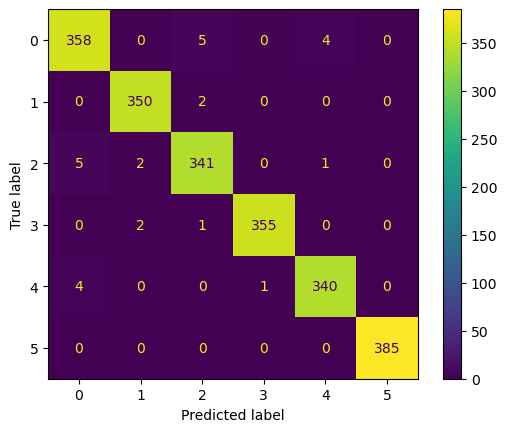


🔹 Top Features per Class:


Class: 0
  Top Positive Features:
    forum: 3.5050
    thread: 3.3109
    supportsiteticket: 2.6933
    supportsiteticket num: 2.6933
    forumcomthread num: 2.6759
    forumcomthread: 2.6759
    wikisitepage num: 2.6561
    wikisitepage: 2.6561
    user: 2.6306
    report: 2.1062
  Top Negative Features:
    num: -1.5672
    num num: -1.5103
    code: -1.4735
    payment: -1.0102
    account: -0.9322
    free: -0.9073
    see: -0.8100
    access: -0.7810
    login: -0.7413
    code num: -0.7261

Class: 1
  Top Positive Features:
    examplecom: 3.1709
    examplecom num: 3.1709
    free: 3.0857
    sale: 2.6653
    shop: 2.2280
    code: 2.2096
    num: 1.9641
    num examplecom: 1.8399
    get: 1.7552
    early: 1.7195
  Top Negative Features:
    code num: -1.1489
    view: -0.9327
    verification: -0.9003
    account: -0.8801
    payment: -0.8428
    update: -0.7827
    required: -0.6956
    security: -0.6675
    reply: -0.6564
    post: -0.6491

Clas

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [39]:
run_logistic_regression(X_train, X_test, y_train, y_test, feature_names=X_tfidf_features)

#### Adding bigrams,trigrams and parts of speech with Tf-Idf

In [23]:
bigrams_trigrams = TfidfVectorizer(ngram_range=(2,3), 
                        max_features=20000, 
                        stop_words="english")

In [29]:
bigram_trigram_frame = bigrams_trigrams.fit_transform(train_df['combined_text'])

In [30]:
bigram_trigram_frame

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 269938 stored elements and shape (10780, 20000)>

In [33]:
def get_pos_tags(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return " ".join([tag for _, tag in pos_tags])

In [36]:
train_df["parts_of_speech"] = train_df["combined_text"].apply(get_pos_tags)

In [37]:
train_df.head()

,id,subject,body,text,category,category_id,combined_text,parts_of_speech
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1,anniversary special buy one get one free loyal...,JJ JJ VB CD NN CD JJ NN NN VBP JJ NN NN NN NN ...
1,spam_1629,Your Amazon was used on new device,Your $5000 refund is processed. Claim: bit.ly/...,Your Amazon was used on new device Your $5000 ...,spam,3,amazon used new device num refund processed cl...,NNS VBD JJ NN NN NN VBD NN NN JJ IN JJ NN NN V...
2,spam_322,Re: Your Google inquiry,"Hi, following up about your Google application...","Re: Your Google inquiry Hi, following up about...",spam,3,google inquiry hi following google application...,NN NN NN VBG JJ NN NNS VBD JJ NN . VB JJ NN NN...
3,social_media_80,Digital Ritual Experience Creation,Cross-cultural ceremony design. Join: virtualr...,Digital Ritual Experience Creation Cross-cultu...,social_media,2,digital ritual experience creation crosscultur...,JJ JJ NN NN JJ NN NN NN NN JJ NN JJ JJ NN NN J...
4,forum_1351,"Your post was moved to ""Programming Help""","Trending: ""cooking"" (258 comments). View: supp...","Your post was moved to ""Programming Help"" Tren...",forum,0,post moved programming help trending cooking n...,NN VBD VBG NN VBG VBG JJ NNS VBP NN NN NN VBD ...


In [44]:
parts_of_speech = train_df.loc[:,'parts_of_speech']

In [45]:
parts_of_speech

0        JJ JJ VB CD NN CD JJ NN NN VBP JJ NN NN NN NN ...
1        NNS VBD JJ NN NN NN VBD NN NN JJ IN JJ NN NN V...
2        NN NN NN VBG JJ NN NNS VBD JJ NN . VB JJ NN NN...
3        JJ JJ NN NN JJ NN NN NN NN JJ NN JJ JJ NN NN J...
4        NN VBD VBG NN VBG VBG JJ NNS VBP NN NN NN VBD ...
                               ...                        
10775    NN NN NN VBD JJ NN NN IN NN NN VBZ NN NN NN VB...
10776    NN VBD NN NN NN JJ NN NNS NN VBN NN VBN NN VBD...
10777    NN NN NN VBD NN NNS VBP NN VBD JJ NN NNS RB VB...
10778    NN VBD JJ NN NN NNS VBN IN NN VBG JJ NN NN NN ...
10779    NN NN VBD JJ NN PRP . JJ JJ NN VBD NN NN NN NN...
Name: parts_of_speech, Length: 10780, dtype: object

In [52]:
pos_vectorizer = CountVectorizer()

In [53]:
pos_features = pos_vectorizer.fit_transform(parts_of_speech)

In [65]:
X_input_1 = hstack([bigram_trigram_frame, pos_features])

In [57]:
bigram_tigram_features = bigrams_trigrams.get_feature_names_out()

In [59]:
pos_features_names = pos_vectorizer.get_feature_names_out()

In [60]:
all_feature_names = np.concatenate([bigram_tigram_features, pos_features_names])

In [66]:
X_train,X_test,y_train,y_test = get_train_test(X_input_1,y,test_size=0.2,random_state=101)

D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



🔹 Accuracy: 0.9583

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       367
           1       0.95      0.97      0.96       352
           2       0.93      0.95      0.94       349
           3       0.97      0.97      0.97       358
           4       0.95      0.96      0.96       345
           5       0.96      0.98      0.97       385

    accuracy                           0.96      2156
   macro avg       0.96      0.96      0.96      2156
weighted avg       0.96      0.96      0.96      2156



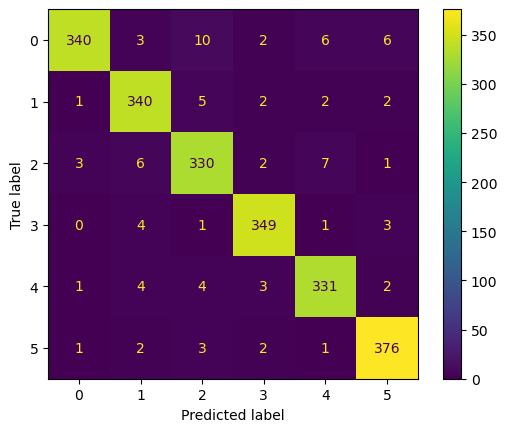


🔹 Top Features per Class:


Class: 0
  Top Positive Features:
    supportsiteticket num: 3.8948
    wikisitepage num: 3.7910
    forumcomthread num: 3.6648
    report num: 1.8294
    thread discussion: 1.7579
    discussion num: 1.7579
    thread discussion num: 1.7579
    report num details: 1.7280
    event starts time: 1.6681
    time prepare: 1.6681
  Top Negative Features:
    num num: -1.3091
    code num: -0.8531
    examplecom num: -0.8372
    prp: -0.6769
    group update: -0.6015
    pin num: -0.5876
    secure account: -0.5721
    invited rsvp: -0.5684
    sale num: -0.5670
    changelog included: -0.5667

Class: 1
  Top Positive Features:
    examplecom num: 3.8267
    num examplecom num: 2.1223
    num examplecom: 2.1223
    sale num: 1.9800
    extra num: 1.9799
    early access: 1.8612
    examplecom num code: 1.6555
    free shipping: 1.5143
    num code: 1.5112
    shop examplecom: 1.3666
  Top Negative Features:
    md: -1.0369
    code num: -0.9923
    wikisitepage 

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'multinomial'


In [67]:
run_logistic_regression(X_train, X_test, y_train, y_test, feature_names=all_feature_names)